# Reinforcement Learning from Human Feedback (RLHF) with GPT-2

This project demonstrates a custom implementation of Reinforcement Learning from Human Feedback (RLHF) using GPT-2, guided by Anthropic’s HH dataset and a lightweight reward model. While full policy optimization via PPO was not completed due to compute constraints, this repository showcases the key components required for an end-to-end RLHF pipeline.

### Project Goals

- Fine-tune a language model using RLHF to produce more helpful responses.
- Train a reward model using preference data based on the Anthropic Helpful dataset.
- Set up a PPO training loop to optimize a frozen GPT-2 model with LoRA adapters.


In [1]:
!pip install transformers==4.51.3
!pip install peft==0.15.2
!pip install accelerate==1.6.0
!pip install datasets==3.6.0
!pip install trl==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

#### Load GPT-2
Use transformers to load GPT-2 from Hugging Face and try a zero-shot propmpt:

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load GPT-2 or DistilGPT2
model_name = "gpt2"  # or "distilgpt2"
model = AutoModelForCausalLM.from_pretrained('gpt2')

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token # Required for padding


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def generate_response(prompt, model, tokenizer):
    prompt = "\n\nHuman:" + prompt + "\n\nAssistant:" # our datset has Human, Assitant format of prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(inputs['input_ids'],
                             attention_mask=inputs['attention_mask'],
                            #  do_sample=True, # to avoid repeating tokens in response
                             max_length=100)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text.split('Assistant:')[-1]

#### Evaluate Responses
Choose a few prompts and print both the generated responses. Without a bit of prompt engineering to format the queries such as `Q:question\nA:`, model will not make a meaningful response. However responses are slightly more confused when the prompt format is "Human:question\nAssistant:" which is the form of examples in our dataset. So finetuning can be a clear improvement. After early steps of fine-tuning, the model should easily pick up this pattern and genrate better responses.

In [ ]:
questions = ["What is Machine Learning?", "What is Overfitting?", "Explain how Photosynthesis works."]
responses = [generate_response(p, model, tokenizer) for p in questions]
for p, r in zip(questions, responses):
    print(f"\n\nHuman: {p}\n\nAssistant: {r}")
    print('-'*20)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




Human: What is Machine Learning?

Assistant:  Machine Learning is a new field of research that has been gaining traction in the last few years. It is a field that has been gaining traction in the last few years. It is a field that has been gaining traction in the last few years. It is a field that has been gaining traction in the last few years. It is a field that has been gaining traction in the last few years. It is a field that has been gaining
--------------------


Human: What is Overfitting?

Assistant:  I'm not sure what you mean
--------------------


Human: Explain how Photosynthesis works.

Assistant: What is the difference between photosynthesis and photosynthesis?

Human:The difference is that photosynthesis is the process of converting sunlight into energy. It is the process of converting the
--------------------


### Why Small Models Repeat Themselves:

1. No Instruction-Tuning
  - They're not trained to follow instructions or stop at a clean endpoint. They just continue generating text that “looks like” what they've seen during pretraining (which often means repeating phrases).
2. Short Context Size
  - They have limited ability to manage coherence over long generations. Repetition is often a fallback when they “run out of ideas.”
3. No Penalization for Repetition
  Without mechanisms like:
    - Repetition penalty
    - Top-k/top-p sampling
    - RLHF fine-tuning

When `do_sample=False`, you're using greedy decoding, which:

  - Always picks the highest-probability next token
  - Often leads to loops and repetition, especially in small models

When `do_sample=True`, you enable sampling (with top_k, top_p, temperature optionally), which:

  - Introduces controlled randomness
  - Breaks out of repetition cycles
  - Produces more diverse and natural responses

Sampling = compute overhead:

Instead of choosing one best token, the model samples from a distribution at each step
This adds latency, especially on Colab or CPU
⚠️ Unfortunately, it's a trade-off:

Greedy = fast but repetitive
Sampling = slower but better qualit


Later, when you fine-tune with RLHF, the model will learn not to repeat because:

- Repetitive outputs will get lower reward scores
- PPO will shift the policy toward preferred, non-repetitive completions


## Load, explore and filter the dataset



In [3]:
from datasets import load_dataset

# Load the HH-RLHF dataset
dataset = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base")

# Access the training split
train_data = dataset["train"]
train_data

README.md:   0%|          | 0.00/5.77k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 43835
})

In [ ]:
train_data[0]

{'chosen': '\n\nHuman: Hi, I want to learn to play horseshoes. Can you teach me?\n\nAssistant: I can, but maybe I should begin by telling you that a typical game consists of 2 players and 6 or 8 horseshoes.\n\nHuman: Okay. What else is needed to play, and what are the rules?\n\nAssistant: A horseshoe is usually made out of metal and is about 3 to 3.5 inches long and around 1 inch thick. The horseshoe should also have a 2 inch by 3 inch flat at the bottom where the rubber meets the metal. We also need two stakes and six horseshoes.',
 'rejected': '\n\nHuman: Hi, I want to learn to play horseshoes. Can you teach me?\n\nAssistant: I can, but maybe I should begin by telling you that a typical game consists of 2 players and 6 or 8 horseshoes.\n\nHuman: Okay. What else is needed to play, and what are the rules?\n\nAssistant: Horseshoes are either metal or plastic discs. The horseshoes come in different weights, and the lighter ones are easier to throw, so they are often the standard for begi

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Add token lengths for chosen and rejected responses
dataset_with_lengths = train_data.map(lambda x: {
    "chosen_length": len(tokenizer.encode(x["chosen"], truncation=False)),
    "rejected_length": len(tokenizer.encode(x["rejected"], truncation=False))
}, remove_columns=["chosen", "rejected"])

chosen_lengths = dataset_with_lengths["chosen_length"]
rejected_lengths = dataset_with_lengths["rejected_length"]

print("Max chosen:", max(chosen_lengths))
print("Max rejected:", max(rejected_lengths))
print("Avg chosen:", sum(chosen_lengths) / len(chosen_lengths))
print("Avg rejected:", sum(rejected_lengths) / len(rejected_lengths))

Map:   0%|          | 0/43835 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1041 > 1024). Running this sequence through the model will result in indexing errors


Max chosen: 1036
Max rejected: 1514
Avg chosen: 194.08312991901448
Avg rejected: 181.75845785331356


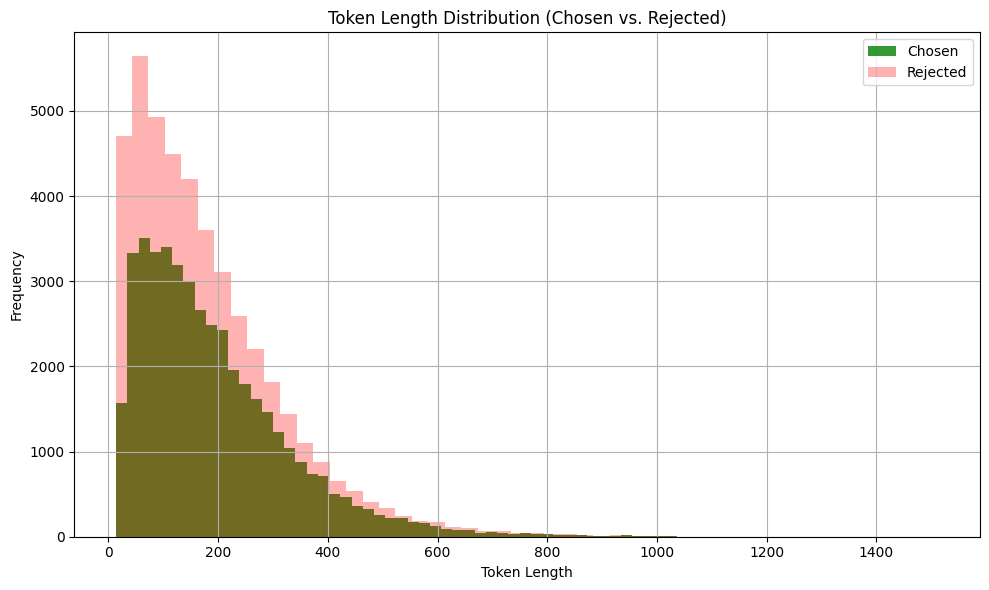

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(chosen_lengths, bins=50, alpha=0.8, label="Chosen", color="green")
plt.hist(rejected_lengths, bins=50, alpha=0.3, label="Rejected", color="red")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution (Chosen vs. Rejected)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Filter too short or too long or similar chosen or rejected examples:

In [4]:
# Compute token lengths and filter where both lengths ≤ 512
from difflib import SequenceMatcher

def similarity_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

train_data = dataset['train'].filter(
    lambda x: (
        len(tokenizer.encode(x["chosen"], truncation=False)) <= 512 and
        len(tokenizer.encode(x["rejected"], truncation=False)) <= 512 and
        len(tokenizer.encode(x["rejected"], truncation=False)) <= 512 and
        len(tokenizer.encode(x["rejected"], truncation=False)) >= 10 and
        similarity_ratio(x["chosen"], x["rejected"]) < 0.9
    )
)

test_data = dataset['test'].filter(
    lambda x: (
        len(tokenizer.encode(x["chosen"], truncation=False)) <= 512 and
        len(tokenizer.encode(x["chosen"], truncation=False)) >= 10 and
        len(tokenizer.encode(x["rejected"], truncation=False)) <= 512 and
        len(tokenizer.encode(x["rejected"], truncation=False)) >= 10 and
        similarity_ratio(x["chosen"], x["rejected"]) < 0.9
    )
)

Filter:   0%|          | 0/43835 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 1024). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/2354 [00:00<?, ? examples/s]

In [5]:
# Perform the train/val split (90% train, 10% val)
split_dataset = train_data.train_test_split(test_size=0.1, seed=42)

# Access train and validation splits
train_data = split_dataset["train"]
val_data = split_dataset["test"]

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

33253
3695
1970


In [ ]:
train_data[0:2]

{'chosen': ['\n\nHuman: Hi, I want to learn to play horseshoes. Can you teach me?\n\nAssistant: I can, but maybe I should begin by telling you that a typical game consists of 2 players and 6 or 8 horseshoes.\n\nHuman: Okay. What else is needed to play, and what are the rules?\n\nAssistant: A horseshoe is usually made out of metal and is about 3 to 3.5 inches long and around 1 inch thick. The horseshoe should also have a 2 inch by 3 inch flat at the bottom where the rubber meets the metal. We also need two stakes and six horseshoes.',
  '\n\nHuman: How do I teach kids to meditate?\n\nAssistant: Great question! That’s a really useful skill to cultivate, it can bring peace, calm, and happiness. I’m glad you want to teach your kids about it.\n\nHuman: All right, so how do we start?\n\nAssistant: Well, we can get started with just being silent. You can tell the kids it’s okay if they just sit there quietly for a few minutes without thinking of anything.\n\nHuman: any other ideas? they are f

## Training Pipeline

In InstructGPT, the training pipeline is:

1. SFT model (Supervised Fine-Tuning on human-written demonstrations)
  - Human-written prompt → good answer pairs
  - Trains a language model (e.g., GPT) to imitate good responses
  - This is the starting point for both the reward model and the PPO model
2. Reward Model
  - Built on top of the SFT model
  - Takes (prompt + response) → scalar reward
  - Trained to score preferred completions higher than rejected ones
3. RLHF with PPO
  - Generator (from SFT) produces responses
  - Reward model scores them
  - PPO adjusts generator to produce higher-reward responses


## Prepare Data

Originally, the data has the format of

```
{
  "chosen": "Human:What is X?\n\nAssistant: This is Y\n\nHuman:How about Z\n\nAssitant: a good answer",
  'rejected': "Human:What is X?\n\nAssistant: This is Y\n\nHuman:How about Z\n\nAssitant: a bad answer"
}
```

We reformat it into the following to be later processed further for different purposes:

```
{
  "prompt": "Human:What is X?\n\nAssistant: This is Y\n\nHuman:How about Z\n\nAssitant:",
  "chosen_response": "a good answer",
  "rejected_response": "a bad answer"
}
```

### Split the Data

In [6]:
def split_prompt_response(full_text):
    # Split from the last occurrence of "Assistant:"
    idx = full_text.rfind("Assistant:")
    prompt = full_text[:idx + len("Assistant:")].strip()
    response = full_text[idx + len("Assistant:"):].strip()
    return prompt, response

def preprocess(example):
    prompt_chosen, resp_chosen = split_prompt_response(example["chosen"])
    prompt_rejected, resp_rejected = split_prompt_response(example["rejected"])

    # Sanity check: prompt_chosen and prompt_rejected should be identical
    if prompt_chosen == prompt_rejected:
      return {
          "prompt": prompt_chosen + " ",
          "chosen_response": resp_chosen,
          "rejected_response": resp_rejected
      }


In [7]:
train_dataset = train_data.map(lambda x: preprocess(x), remove_columns=['chosen', 'rejected'])
val_dataset = val_data.map(lambda x: preprocess(x), remove_columns=['chosen', 'rejected'])
test_dataset = test_data.map(lambda x: preprocess(x), remove_columns=['chosen', 'rejected'])

Map:   0%|          | 0/33253 [00:00<?, ? examples/s]

Map:   0%|          | 0/3695 [00:00<?, ? examples/s]

Map:   0%|          | 0/1970 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['prompt', 'chosen_response', 'rejected_response'],
    num_rows: 33134
})
Dataset({
    features: ['prompt', 'chosen_response', 'rejected_response'],
    num_rows: 3681
})
Dataset({
    features: ['prompt', 'chosen_response', 'rejected_response'],
    num_rows: 1961
})


In [ ]:
train_dataset[0]

{'prompt': 'Human: How do I sanitize a toothbrush?\n\nAssistant: ',
 'chosen_response': 'I can give you the most accurate information about how to sanitize a toothbrush.',
 'rejected_response': 'You want to clean a toothbrush?'}


# Supervised Fine-Tuning of Base Model

Supervised Fine-Tuning (SFT), and it's exactly what OpenAI, Anthropic, and others do as the first stage of RLHF training.

✅ Why SFT is Important Before RLHF

1. Warms up the model
  - Helps the model learn the format and style of helpful responses.
  - Without this step, PPO starts from a weaker baseline and takes longer to converge.
2. Stabilizes PPO
  - PPO is sensitive to initial conditions. A supervised model trained on preferred responses is a much better starting point than a raw pretrained one.
3. Improves reward model quality
  - A stronger SFT model generates better responses for training your reward model too.

## Tokenize and Create Labels

If you're fine-tuning a language model (such as GPT-2) to predict responses based on prompts, here's why you'd need both:

- Attention Mask: This prevents the model from focusing on the prompt tokens while predicting the response. You use it to tell the model, "Hey, ignore the prompt and only focus on the response during training."

- Masked Labels: This ensures that the model doesn’t attempt to predict the prompt tokens. It will only predict the response tokens. So, the prompt tokens in the labels are set to -100, so the model is not penalized for predicting the prompt.

In [ ]:
def tokenize_sft(example):
    prompt = example["prompt"]
    response = example["chosen_response"]

    # No padding or truncation here
    prompt_tokens = tokenizer(prompt, add_special_tokens=False)["input_ids"]
    response_tokens = tokenizer(response, add_special_tokens=False)["input_ids"]

    input_ids = prompt_tokens + response_tokens
    labels = [-100] * len(prompt_tokens) + response_tokens

    assert len(input_ids) == len(labels)

    return {"input_ids": input_ids, "labels": labels}



In [ ]:
# Apply tokenization to all splits
tokenized_train = train_dataset.map(tokenize_sft, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(tokenize_sft, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(tokenize_sft, remove_columns=test_dataset.column_names)


Map:   0%|          | 0/33134 [00:00<?, ? examples/s]

Map:   0%|          | 0/3681 [00:00<?, ? examples/s]

Map:   0%|          | 0/1961 [00:00<?, ? examples/s]

In [ ]:
# Check a sample for correct alignment
sample = tokenized_train[3]
print(f"input_ids: {sample['input_ids']}")
print(f"labels: {sample['labels']}")

print(len(sample["input_ids"]))
print(len(sample["labels"]))

input_ids: [20490, 25, 1867, 389, 2842, 326, 661, 8156, 2691, 1830, 284, 22705, 1028, 584, 1938, 30, 198, 198, 48902, 25, 2141, 345, 1612, 617, 2176, 1830, 11, 588, 564, 250, 21926, 77, 578, 447, 251, 30, 198, 198, 20490, 25, 921, 460, 22705, 319, 6401, 77, 578, 30, 198, 198, 48902, 25, 1002, 345, 467, 656, 262, 6460, 290, 2251, 257, 649, 1848, 11, 345, 460, 788, 4654, 584, 2460, 287, 257, 564, 250, 29800, 12, 7829, 447, 251, 983, 351, 606, 13, 220, 1406, 345, 447, 247, 67, 991, 307, 2712, 262, 976, 983, 11, 475, 355, 257, 4553, 2095, 13, 198, 198, 20490, 25, 3966, 13, 1374, 318, 326, 21608, 13, 198, 198, 48902, 25, 921, 447, 247, 67, 307, 9679, 262, 976, 995, 355, 584, 1938, 11, 475, 287, 281, 5000, 1180, 2095, 11, 351, 645, 4133, 11, 290, 645, 761, 329, 1938, 284, 9427, 351, 345, 13, 220, 383, 749, 2219, 1517, 661, 466, 318, 284, 655, 2513, 1088, 290, 1011, 3404, 422, 661, 326, 3588, 447, 247, 83, 511, 3435, 13, 198, 198, 20490, 25, 7900, 13, 198, 198, 48902, 25, 220, 40, 447, 247, 7

In [ ]:
tokenized_train

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 33134
})

In [ ]:
len(tokenized_train[0]["input_ids"])

35

In [ ]:
len(tokenized_train[1]["input_ids"])

105

### Load the base model and apply PEFT LoRA:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType


# Load GPT-2 base model and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

# Define LoRA config
lora_config = LoraConfig(
    r=8,                          # Low-rank dimension
    lora_alpha=32,                # Scaling factor
    # Target GPT-2's attention projection layer (c_attn), attention output layer (c_proj), MLP input/output (mlp.c_fc, mlp.c_proj)
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to the model
sft_model = get_peft_model(model, lora_config)
sft_model.print_trainable_parameters()  # Only LoRA params will be trainable


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Then add Data Collator for Dynamic Padding. This helps with efficient training...

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=sft_model,
    label_pad_token_id=-100,
    padding=True
)

Set up Training Arguments + Trainer

In [ ]:
from transformers import TrainingArguments, Trainer, get_scheduler, DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors="pt")


training_args = TrainingArguments(
    output_dir="./peft-sft-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=5e-5,
    lr_scheduler_type="linear",  # Use linear scheduler
    warmup_steps=1000,
    fp16=True,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=sft_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

<ipython-input-20-9ae36cbff62c>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
1000,2.697000,2.376763
2000,2.465000,2.334388
3000,2.426300,2.319760
4000,2.424500,2.311311
5000,2.407800,2.306845
6000,2.399400,2.302166
7000,2.399300,2.301657
8000,2.394500,2.298506
9000,2.387400,2.296175
10000,2.383500,2.295663


TrainOutput(global_step=10355, training_loss=2.436593384791088, metrics={'train_runtime': 1431.5925, 'train_samples_per_second': 115.724, 'train_steps_per_second': 7.233, 'total_flos': 3.2850617984188416e+16, 'train_loss': 2.436593384791088, 'epoch': 5.0})

It is a good idea to save trained models properly so they can be loaded easily when needed. Note that when you train a PEFT model (like LoRA) using the Hugging Face Trainer, the `model.save_pretrained()` only saves the adapter weights, not the entire base model, which is a light save. This is exactly how PEFT works by design. When loading the model, the base can be loaded using `from_pretrained()` method of HuggingFace. The LoRA adapter will be loaded separately and added to the base. If you need to have both parts unified as a single model (becomes significantly larger in size), merge base model and the adapter into a single model.

In [ ]:
sft_model.save_pretrained("./sft-model/sft-gpt2")
tokenizer.save_pretrained("./sft-model/sft-gpt2")

('./sft-model/sft-gpt2/tokenizer_config.json',
 './sft-model/sft-gpt2/special_tokens_map.json',
 './sft-model/sft-gpt2/vocab.json',
 './sft-model/sft-gpt2/merges.txt',
 './sft-model/sft-gpt2/added_tokens.json',
 './sft-model/sft-gpt2/tokenizer.json')

Zip it before downloading:

In [ ]:
!zip -r sft-gpt2.zip ./sft-model/sft-gpt2

  adding: sft-model/sft-gpt2/ (stored 0%)
  adding: sft-model/sft-gpt2/adapter_model.safetensors (deflated 7%)
  adding: sft-model/sft-gpt2/merges.txt (deflated 53%)
  adding: sft-model/sft-gpt2/special_tokens_map.json (deflated 60%)
  adding: sft-model/sft-gpt2/vocab.json (deflated 59%)
  adding: sft-model/sft-gpt2/tokenizer.json (deflated 82%)
  adding: sft-model/sft-gpt2/tokenizer_config.json (deflated 54%)
  adding: sft-model/sft-gpt2/adapter_config.json (deflated 55%)
  adding: sft-model/sft-gpt2/README.md (deflated 66%)


In [ ]:
from google.colab import files
files.download("sft-gpt2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test Inference

Load SFT model after merging the base GPT2 with language model head (GPT2LMHeadModel) + PEFT component to generate some text from our fine-tuned model:

In [8]:
from transformers import GPT2LMHeadModel, AutoTokenizer
from peft import PeftModel, PeftConfig

def load_sft_model_GPT2LMHead(peft_model_path):
    """
    Loads a fine-tuned GPT-2 model with PEFT (LoRA).

    Args:
        peft_model_path (str): Path to the PEFT model directory.

    Returns:
        model: The fine-tuned SFT model ready for text generation.
        tokenizer: The tokenizer corresponding to the base GPT-2 model.
    """

    # Load the tokenizer for GPT-2
    tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

    # Useful to be explicit about using GPT2LMHeadModel when loading gpt2
    base_model = GPT2LMHeadModel.from_pretrained("gpt2")

    # Load LoRA (PEFT) adapter on top
    model = PeftModel.from_pretrained(base_model, peft_model_path)

    # Use this if you want to merge the LoRA adapter into the base model to become one piece.
    # sft_model = model.merge_and_unload()

    return model, tokenizer

In [ ]:
import torch

# Load sft_model
sft_model, tokenizer = load_sft_model_GPT2LMHead("./sft-model/sft-gpt2")

# Move model to the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sft_model.to(device)

prompt = "Human: What are the benefits of daily meditation?\n\nAssistant:"
inputs = tokenizer(prompt, return_tensors="pt").to(sft_model.device)

# Generate a response
with torch.no_grad():
    output = sft_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id  # suppress warning
    )

# Decode and print
response = tokenizer.decode(output[0], skip_special_tokens=True)
print("\nGenerated Response:\n")
print(response)



Generated Response:

Human: What are the benefits of daily meditation?

Assistant:It’s very important to practice mindfulness, and it’s important to understand what meditation is. It’s easy to forget that you are meditating, and that meditation is just a way of being. This is something you can experience as a person, in your own way, in a way that you can actually feel yourself in the moment. It’s a way of feeling, because you don’t have to look at your own thoughts and feelings. You can


We can see some improvement there.

## Reward Model

- Architecture: Frozen GPT-2 + LoRA and a trainable linear reward head.
- Input: Paired prompts with preferred and rejected completions.
- Output: Scalar reward signal based on mean-pooled hidden states.
- Training: Supervised preference loss (pairwise ranking).
- Result: Working reward model capable of scoring responses with meaningful scalar outputs.


Here's how you can approach it:

- Load the LoRA-fine-tuned model (either merged or adapter-based) as the base model.
- Build the reward head on top of it — typically a simple feed-forward layer (MLP) for reward prediction.
- Train the reward model with prepared data (e.g., pair of chosen_response and rejected_response).


## Prepare Data for RM

Split both chosen and rejected into:

- prompt: everything before "Assistant:"
- response_chosen: everything after "Assistant:" in chosen
- response_rejected: everything after "Assistant:" in rejected

Examples enter the model as pairs: prompt+chosen_responses, prompt+rejected_responses. Subtract the scalar output and apply the loss (soft or hard)


In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# Load the GPT2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("./sft-model/sft-gpt2")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
def tokenize_reward(example, tokenizer):
    chosen_input = example["prompt"] + example["chosen_response"]
    rejected_input = example["prompt"] + example["rejected_response"]

    chosen_enc = tokenizer(chosen_input, truncation=True)
    rejected_enc = tokenizer(rejected_input, truncation=True)

    return {
        "input_ids_chosen": chosen_enc["input_ids"],
        "attention_mask_chosen": chosen_enc["attention_mask"],
        "input_ids_rejected": rejected_enc["input_ids"],
        "attention_mask_rejected": rejected_enc["attention_mask"]
    }


In [ ]:
from functools import partial

# Partial to inject tokenizer argument
tokenize_fn = partial(tokenize_reward, tokenizer=tokenizer)

tokenized_train_dataset = train_dataset.map(
    tokenize_fn,
    remove_columns=train_dataset.column_names,
    batched=False
)

tokenized_val_dataset = val_dataset.map(
    tokenize_fn,
    remove_columns=val_dataset.column_names,
    batched=False
)

tokenized_test_dataset = test_dataset.map(
    tokenize_fn,
    remove_columns=test_dataset.column_names,
    batched=False
)

Map:   0%|          | 0/33134 [00:00<?, ? examples/s]

Map:   0%|          | 0/3681 [00:00<?, ? examples/s]

Map:   0%|          | 0/1961 [00:00<?, ? examples/s]

In [ ]:
class RewardDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.pad = DataCollatorWithPadding(tokenizer, return_tensors="pt")

    def __call__(self, batch):
        # Separate chosen and rejected inputs
        chosen = [{"input_ids": x["input_ids_chosen"], "attention_mask": x["attention_mask_chosen"]} for x in batch]
        rejected = [{"input_ids": x["input_ids_rejected"], "attention_mask": x["attention_mask_rejected"]} for x in batch]

        chosen_batch = self.pad(chosen)
        rejected_batch = self.pad(rejected)

        return {
            "input_ids_chosen": chosen_batch["input_ids"],
            "attention_mask_chosen": chosen_batch["attention_mask"],
            "input_ids_rejected": rejected_batch["input_ids"],
            "attention_mask_rejected": rejected_batch["attention_mask"]
        }


In [ ]:
from torch.utils.data import DataLoader

collator = RewardDataCollator(tokenizer)

train_loader = DataLoader(tokenized_train_dataset, batch_size=16, shuffle=True, collate_fn=collator)
val_loader   = DataLoader(tokenized_val_dataset, batch_size=16, shuffle=False, collate_fn=collator)
test_loader  = DataLoader(tokenized_test_dataset, batch_size=16, shuffle=False, collate_fn=collator)

In [ ]:
# Check dynamic padding ...
from torch.utils.data import DataLoader
batch = next(iter(train_loader))

for k, v in batch.items():
    print(k, v.shape)

input_ids_chosen torch.Size([64, 457])
attention_mask_chosen torch.Size([64, 457])
input_ids_rejected torch.Size([64, 391])
attention_mask_rejected torch.Size([64, 391])


# Training Reward Model



Now that we have:

- A custom reward model wrapping your SFT model (e.g., GPT2 + scalar head)
- A tokenized dataset with (input_ids_chosen, input_ids_rejected, ...) for each pair

We're ready for a custom training pipeline — since this isn't a standard supervised task, we need to define a custom loss and batch handling. We want to define a Reward Model based on out SFT gpt2 (using PEFT/LoRA) such that

- It has a custom reward head
- Compatible with Hugging Face’s save_pretrained() and from_pretrained().


In [ ]:
!unzip sft-gpt2.zip -d .

Archive:  sft-distilgpt2.zip
   creating: ./sft-model/sft-distilgpt2/
  inflating: ./sft-model/sft-distilgpt2/special_tokens_map.json  
  inflating: ./sft-model/sft-distilgpt2/adapter_model.safetensors  
  inflating: ./sft-model/sft-distilgpt2/vocab.json  
  inflating: ./sft-model/sft-distilgpt2/tokenizer.json  
  inflating: ./sft-model/sft-distilgpt2/adapter_config.json  
  inflating: ./sft-model/sft-distilgpt2/README.md  
  inflating: ./sft-model/sft-distilgpt2/tokenizer_config.json  
  inflating: ./sft-model/sft-distilgpt2/merges.txt  


In [9]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel

class RewardModel(nn.Module):
    def __init__(self, base_model: GPT2LMHeadModel, hidden_size=768):
        super().__init__()

        # Keep GPT-2 base model as is
        self.base_model = base_model

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Get hidden size from config
        hidden_size = self.base_model.config.hidden_size

        # Reward head: simple linear layer
        self.reward_head = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        # Enable output of hidden states
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
        )

        # Get last hidden layer
        last_hidden = outputs.hidden_states[-1]  # shape: (batch_size, seq_len, hidden_dim)

        # Mean pooling over non-padded tokens
        mask = attention_mask.unsqueeze(-1).float()  # shape: (batch_size, seq_len, 1)
        summed = (last_hidden * mask).sum(dim=1)     # shape: (batch_size, hidden_dim)
        counts = mask.sum(dim=1)                     # shape: (batch_size, 1)
        pooled = summed / counts                     # shape: (batch_size, hidden_dim)

        # Pass through reward head
        reward = self.reward_head(pooled).squeeze(-1)  # shape: (batch_size,)
        return reward


In [ ]:
sft_model, tokenizer = load_sft_model_GPT2LMHead("./sft-model/sft-gpt2")

# Initialize the reward model
reward_model = RewardModel(base_model=sft_model)

In [ ]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids_chosen = batch["input_ids_chosen"].to(device)
            attention_mask_chosen = batch["attention_mask_chosen"].to(device)
            input_ids_rejected = batch["input_ids_rejected"].to(device)
            attention_mask_rejected = batch["attention_mask_rejected"].to(device)

            reward_chosen = model(input_ids_chosen, attention_mask_chosen)
            reward_rejected = model(input_ids_rejected, attention_mask_rejected)

            correct += (reward_chosen > reward_rejected).sum().item()
            total += input_ids_chosen.size(0)

    accuracy = correct / total
    print(f"✅ Validation accuracy: {accuracy * 100:.2f}%")
    return accuracy

You must do both:

Freeze the backbone:
```python
for param in model.backbone.parameters():
    param.requires_grad = False
```
Pass only the reward head to the optimizer:
```python
optimizer = torch.optim.Adam(model.reward_head.parameters(), lr=1e-4)
```
🔍 Why both are necessary:
Freezing with .requires_grad = False ensures no gradients are computed or stored for GPT-2 layers, saving memory and compute.
Specifying model.reward_head.parameters() in the optimizer ensures that only the reward head is updated during optimizer.step().
⚠️ If you skip freezing, even though the optimizer won't update the backbone, gradients will still be computed for it — wasting memory and compute.
If you skip passing only the reward head to the optimizer, the optimizer might include unintended trainable parts if requires_grad was accidentally left True somewhere.

In [ ]:
# Set the optimizer to update only the reward head
optimizer = torch.optim.AdamW(reward_model.reward_head.parameters(), lr=2e-4)

def preference_loss(reward_chosen, reward_rejected):
    return -torch.nn.functional.logsigmoid(reward_chosen - reward_rejected).mean()

In [ ]:
# Double-check what's being updated
for name, param in reward_model.named_parameters():
    if param.requires_grad:
        print(f"Training: {name}")

Training: reward_head.weight
Training: reward_head.bias


In [ ]:
from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model.to(device)


# Training loop
epochs = 5

for epoch in range(epochs):
    reward_model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids_chosen = batch["input_ids_chosen"].to(device)
        attention_mask_chosen = batch["attention_mask_chosen"].to(device)
        input_ids_rejected = batch["input_ids_rejected"].to(device)
        attention_mask_rejected = batch["attention_mask_rejected"].to(device)

        reward_chosen = reward_model(input_ids_chosen, attention_mask_chosen)
        reward_rejected = reward_model(input_ids_rejected, attention_mask_rejected)

        loss = preference_loss(reward_chosen, reward_rejected)

        # labels = torch.ones_like(reward_chosen)  # MarginRankingLoss expects label=1 if first input should be ranked higher
        # loss_fn = MarginRankingLoss(margin=0.5)
        # loss = loss_fn(reward_chosen, reward_rejected, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\n✅ Epoch {epoch+1} completed. Avg train loss: {avg_loss:.4f}")

    # Optional: switch to eval mode before validation
    reward_model.eval()
    evaluate(reward_model, val_loader)


Epoch 1: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 1 completed. Avg train loss: 0.6534
✅ Validation accuracy: 65.25%


Epoch 2: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 2 completed. Avg train loss: 0.6293
✅ Validation accuracy: 65.80%


Epoch 3: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 3 completed. Avg train loss: 0.6250
✅ Validation accuracy: 66.34%


Epoch 4: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 4 completed. Avg train loss: 0.6227
✅ Validation accuracy: 66.01%


Epoch 5: 100%|██████████| 518/518 [03:44<00:00,  2.30it/s]



✅ Epoch 5 completed. Avg train loss: 0.6209
✅ Validation accuracy: 66.37%


Epoch 6: 100%|██████████| 518/518 [03:44<00:00,  2.30it/s]



✅ Epoch 6 completed. Avg train loss: 0.6198
✅ Validation accuracy: 66.10%


Epoch 7: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 7 completed. Avg train loss: 0.6188
✅ Validation accuracy: 65.91%


Epoch 8: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 8 completed. Avg train loss: 0.6174
✅ Validation accuracy: 66.07%


Epoch 9: 100%|██████████| 518/518 [03:43<00:00,  2.32it/s]



✅ Epoch 9 completed. Avg train loss: 0.6170
✅ Validation accuracy: 66.01%


Epoch 10: 100%|██████████| 518/518 [03:44<00:00,  2.31it/s]



✅ Epoch 10 completed. Avg train loss: 0.6163
✅ Validation accuracy: 66.29%


In [ ]:
# Save the final reward model
import os
import torch

# Create directory if it doesn't exist
save_path = "./reward-model/rm-gpt2"
os.makedirs(save_path, exist_ok=True)

# Save model weights
torch.save(reward_model.state_dict(), os.path.join(save_path, "pytorch_model.bin"))

# Save tokenizer
tokenizer.save_pretrained(save_path)

# # Optional: Save model architecture info (if needed later)
# with open(os.path.join(save_path, "config.txt"), "w") as f:
#     f.write("RewardModel with GPT2 base")

('./reward-model/rm-gpt2/tokenizer_config.json',
 './reward-model/rm-gpt2/special_tokens_map.json',
 './reward-model/rm-gpt2/vocab.json',
 './reward-model/rm-gpt2/merges.txt',
 './reward-model/rm-gpt2/added_tokens.json',
 './reward-model/rm-gpt2/tokenizer.json')

In [ ]:
# Run final evaluation on the test set
evaluate(reward_model, test_loader)

✅ Validation accuracy: 64.66%


0.6466088730239674

Not bad for GPT-2 based reward model. Save and download the model.

In [ ]:
!zip -r rm-gpt2.zip ./reward-model/rm-gpt2

  adding: reward-model/rm-gpt2/ (stored 0%)
  adding: reward-model/rm-gpt2/pytorch_model.bin (deflated 7%)
  adding: reward-model/rm-gpt2/merges.txt (deflated 53%)
  adding: reward-model/rm-gpt2/special_tokens_map.json (deflated 80%)
  adding: reward-model/rm-gpt2/vocab.json (deflated 59%)
  adding: reward-model/rm-gpt2/tokenizer.json (deflated 82%)
  adding: reward-model/rm-gpt2/tokenizer_config.json (deflated 54%)


In [ ]:
from google.colab import files
files.download("rm-gpt2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load the RM
This helper function is handy when we we want to relaod the model.

In [10]:
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer

def load_reward_model(save_path: str, base_model: GPT2LMHeadModel):
    """
    Load the reward model from disk.

    Args:
        save_path (str): Path to saved model directory.
        reward_model_class (class): Your RewardModel class.
        base_model_name (str): Name or path of base model (e.g., "gpt2-lora-merged").

    Returns:
        reward_model (nn.Module): Loaded reward model.
        tokenizer: Corresponding tokenizer.
    """
    import os


    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(save_path)

    # Rebuild reward model
    reward_model = RewardModel(base_model)
    reward_model.load_state_dict(torch.load(os.path.join(save_path, "pytorch_model.bin"), map_location=device))
    reward_model.eval()

    print(f"✅ Reward model and tokenizer loaded from {save_path}")
    return reward_model, tokenizer

# Proximal Policy Optimization (PPO)

We're now at the third and final stage of RLHF pipeline: Reinforcement Learning via PPO (Proximal Policy Optimization). This is where your reward model guides further training of the SFT model to align better with human preferences.

## What We Have Now: Component	Status

SFT Model	✅ Fine-tuned with LoRA

Reward Model	✅ Trained

Dataset	✅ HH-rlhf (Anthropic)

## What Gets Plugged into PPO?

1. **Policy Model** — the model you’re training further (start from the SFT model)

2. **Reward Model** — frozen; gives a scalar reward for outputs

3. **Prompt Dataset** — used to sample prompts for generation


RLHF PPO Pipeline:

- Utilized Hugging Face’s TRL library for PPO training.
- Query generation and response sampling implemented with left-padding fix and attention masks.
- Reward signal from reward model integrated into the PPO training loop.

Upload the compressed model artifacts and load them properly:

In [12]:
!unzip sft-gpt2.zip -d .
!unzip rm-gpt2.zip -d .

Archive:  sft-gpt2.zip
replace ./sft-model/sft-gpt2/adapter_model.safetensors? [y]es, [n]o, [A]ll, [N]one, [r]ename: ya
  inflating: ./sft-model/sft-gpt2/adapter_model.safetensors  
replace ./sft-model/sft-gpt2/merges.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./sft-model/sft-gpt2/merges.txt  
  inflating: ./sft-model/sft-gpt2/special_tokens_map.json  
  inflating: ./sft-model/sft-gpt2/vocab.json  
  inflating: ./sft-model/sft-gpt2/tokenizer.json  
  inflating: ./sft-model/sft-gpt2/tokenizer_config.json  
  inflating: ./sft-model/sft-gpt2/adapter_config.json  
  inflating: ./sft-model/sft-gpt2/README.md  
Archive:  rm-gpt2.zip
   creating: ./reward-model/rm-gpt2/
  inflating: ./reward-model/rm-gpt2/pytorch_model.bin  
  inflating: ./reward-model/rm-gpt2/merges.txt  
  inflating: ./reward-model/rm-gpt2/special_tokens_map.json  
  inflating: ./reward-model/rm-gpt2/vocab.json  
  inflating: ./reward-model/rm-gpt2/tokenizer.json  
  inflating: ./reward-model/rm-gpt2/tokenize

Loads the SFT model with LoRA, the reference model, and sets up PPO training.
    
    Args:
        peft_model_path (str): Path to the trained LoRA adapter for the model.
        reward_model_path (str): Path to the reward model, typically the same LoRA model.
    
    Returns:
        model (PeftModel): LoRA-adapted model ready for PPO.
        tokenizer (AutoTokenizer): Tokenizer compatible with the model.
        ref_model (AutoModelForCausalLMWithValueHead): Reference model for PPO.
        ppo_config (PPOConfig): PPO configuration object.

During PPO, both the policy head (language generation) and the value head are trained.

✅ LoRA adapter layers are updated — so yes, you're training the actual policy network.
✅ The value head is also trained — it estimates expected reward.
❌ The base GPT-2 weights are frozen if you're only using LoRA and haven't merged the adapters.

So if you're using LoRA:

🟢 Only the LoRA weights and value head are updated during PPO.
If you’ve merged the LoRA weights into the base model (`merge_and_unload()`), then everything is trainable.

If your SFT policy model is GPT-2 + LoRA, then your reference model should be the same (i.e., GPT-2 + LoRA, but frozen).
You shouldn’t compare PPO-updated LoRA weights against a bare GPT-2 base.

During PPO, both the policy head (language generation) and the value head are trained.

✅ LoRA adapter layers are updated — so yes, you're training the actual policy network.
✅ The value head is also trained — it estimates expected reward.
❌ The base GPT-2 weights are frozen if you're only using LoRA and haven't merged the adapters.
So if you're using LoRA:

🟢 Only the LoRA weights and value head are updated during PPO.
If you’ve merged the LoRA weights into the base model (merge_and_unload()), then everything is trainable.

Both policy and ref_model are LoRA-augmented GPT-2
But policy is trainable, ref_model is frozen


You're using AutoModelForCausalLMWithValueHead, which is a wrapper model used in PPO fine-tuning from TRL.
However, unlike Hugging Face’s AutoModelForCausalLM, it does not have a generation_config attribute by default.

PPOTrainer internally tries to call .generate() using that attribute if not overridden. To fix this, Before training, manually assign a generation_config to the model:Do this after wrapping the model with AutoModelForCausalLMWithValueHead or however you're instantiating policy_model.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
from trl import AutoModelForCausalLMWithValueHead

# 1. Load the tokenizer
peft_model_path = "./sft-model/sft-gpt2"
reward_model_path = "./reward-model/rm-gpt2"

tokenizer = AutoTokenizer.from_pretrained(peft_model_path)
# tokenizer.pad_token = tokenizer.eos_token  # GPT-2 does not have a pad token

# 2. Load policy model (base + LoRA + value head)
# Load base model
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
# Load LoRA adapter onto base
lora_model = PeftModel.from_pretrained(base_model, peft_model_path)
# Convert to value head (after LoRA)
policy_model = AutoModelForCausalLMWithValueHead.from_pretrained(lora_model)
policy_model.to(device)

# 3. Load reference model (frozen base GPT-2 for reward comparison)
ref_base = GPT2LMHeadModel.from_pretrained("gpt2")
# Apply LoRA to ref model with same config
ref_model = PeftModel.from_pretrained(ref_base, peft_model_path)
ref_model.eval()  # Don't update reference model during PPO training
ref_model.to(device)

# 4. Load the reward model (can be same as the trained SFT model)
sft_model, _ = load_sft_model_GPT2LMHead(peft_model_path)
reward_model, _ = load_reward_model(reward_model_path, sft_model)
reward_model.to(device)


✅ Reward model and tokenizer loaded from ./reward-model/rm-gpt2


RewardModel(
  (base_model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): GPT2LMHeadModel(
        (transformer): GPT2Model(
          (wte): Embedding(50257, 768)
          (wpe): Embedding(1024, 768)
          (drop): Dropout(p=0.1, inplace=False)
          (h): ModuleList(
            (0-11): 12 x GPT2Block(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): GPT2Attention(
                (c_attn): lora.Linear(
                  (base_layer): Conv1D(nf=2304, nx=768)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=2304, bias=False)
                  )
                  (lora_embedding_A): Parame

Prepare data for this part. We only need the prompts in our data. Policy model generate responses on these prompts and PPO uses the reward model to guide the policy toward hight return which in our case is more alignment to the humam preferences: _helpfulness_!

In [53]:
# Tokenize prompt only
def tokenize_prompt(example):
    tokenized = tokenizer(
        example["prompt"],
        truncation=True
    )

    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
    }

# Apply to train/val/test
tokenized_train = train_dataset.map(tokenize_prompt, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(tokenize_prompt, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(tokenize_prompt, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/33134 [00:00<?, ? examples/s]

Map:   0%|          | 0/3681 [00:00<?, ? examples/s]

Map:   0%|          | 0/1961 [00:00<?, ? examples/s]

In [17]:
tokenized_train

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 33134
})

In [101]:
from transformers import DataCollatorWithPadding

# Use tokenizer-aware dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


Here is the config for PPO using **trl** (Transformer Reinforcement Learning) library from HF:

In [102]:
from trl import PPOTrainer, PPOConfig
from torch.optim import Adam


ppo_config = PPOConfig(
    model_name=None,  # Can specify other model names if needed
    learning_rate=5e-6,
    ppo_epochs=10,
    batch_size=8,
    mini_batch_size=8,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
)

# We make sure to use `Adam` optimizer on the model parameters that require gradients.
optimizer = Adam(filter(lambda p: p.requires_grad, policy_model.parameters()), lr=ppo_config.learning_rate)


ppo_trainer = PPOTrainer(
    ppo_config,
    model=policy_model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=tokenized_train,
    data_collator=data_collator,
    optimizer=optimizer,
)


In [94]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(
        dataset=tokenized_val,
        batch_size=ppo_config.batch_size,
        shuffle=True,
        collate_fn=data_collator
    )

Here is PPO training loop. This part takes significant time ~5h on A100 GPU with 40GB on Colab for a small model such as GPT-2. This loop alos evaluates the progress of policy model on validation data with the judgment of reward model:

In [103]:
import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Assume the following are already defined:
# - policy_model (PeftModel with value head)
# - ref_model (frozen reference model)
# - reward_model (frozen reward model)
# - tokenizer (loaded from peft_model_path)
# - tokenized_train, tokenized_val, tokenized_test (pre-tokenized datasets)
# - ppo_config (instance of PPOConfig)

# tokenizer.padding_side = 'left'

# Training loop
n_epochs = 3  # Set as needed
for epoch in range(n_epochs):
    print(f"\n🚀 Epoch {epoch + 1}/{n_epochs}")
    policy_model.train()

    for step, batch in enumerate(tqdm(ppo_trainer.dataloader)):
        input_ids = batch["input_ids"].to(device)
        # print(input_ids)
        # break
        # Queries mus be a list of tensors!
        query_tensor = [ids.squeeze(0) for ids in input_ids]
        # print(query_tensor[:5])
        # print(len(query_tensor))
        # break
        attention_mask = batch["attention_mask"].to(device)

        # Generate responses (greedy or sampled)
        generation_kwargs = {"max_new_tokens": 50,
                             "do_sample": True,
                             "top_k": 50,
                             "top_p": 0.95,
                             "pad_token_id": tokenizer.eos_token_id,
                            #  "attention_mask": attention_mask
                             }

        responses = ppo_trainer.generate(query_tensor=query_tensor, **generation_kwargs)

        # print(len(responses))
        # print(responses[0:5])
        # break

        # Compute rewards from reward model
        reward_model.eval()
        with torch.no_grad():
            # List of 1D tensors → Pad to tensor of shape [batch_size, max_len]
            responses_padded = pad_sequence(responses, batch_first=True, padding_value=tokenizer.pad_token_id)
            response_attention_mask = (responses_padded != tokenizer.pad_token_id).long()

            # Get rewards from reward model (check if it's returning a tuple)
            rewards_output = reward_model(responses_padded, attention_mask=response_attention_mask).to(device)

            # ppo_trainer requires a list of reward tensors
            rewards = [r.unsqueeze(0) for r in rewards_output]
        # print(rewards[:5])

        # Run PPO step
        stats = ppo_trainer.step(query_tensor, responses, rewards)
        ppo_trainer.log_stats(stats, batch, rewards)


    # Save checkpoint
    torch.save(policy_model.state_dict(), "./ppo_checkpoints/epoch_1/model_with_value_head.pt")
    print(f"💾 Checkpoint saved at: {checkpoint_path}")

    # Optional: Evaluate on validation set
    policy_model.eval()
    all_rewards = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            query_tensor = [ids for ids in input_ids]
            generated = ppo_trainer.generate(query_tensor=query_tensor, max_new_tokens=50)
            generated_padded = pad_sequence(generated, batch_first=True, padding_value=tokenizer.pad_token_id)
            generated_attention_mask = (generated_padded != tokenizer.pad_token_id).long()

            reward = reward_model(generated, attention_mask=generated_attention_mask)
            all_rewards.extend(reward.cpu().tolist())

    avg_reward = sum(all_rewards) / len(all_rewards)
    print(f"📊 Average validation reward: {avg_reward:.4f}")



🚀 Epoch 1/3


  0%|          | 0/4141 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|          | 1/4141 [00:05<6:22:45,  5.55s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tok

KeyboardInterrupt: 

PPO itself only requires: (query, response, reward) tuples.
Reward_model is typically custom (e.g. yours with a mean-pooled GPT-2 + linear head), so:
- You compute rewards using it manually.
- Then you pass those computed scalar rewards to `ppo_trainer.step()`.

I was about to ran out of compute units. So interrupted the process and save the model:*italicized text*

In [106]:
# Save the full model state dict (includes value head)
! mkdir -p ./ppo_checkpoints/epoch_1
torch.save(policy_model.state_dict(), "./ppo_checkpoints/epoch_1/model_with_value_head.pt")

# Save tokenizer and config
tokenizer.save_pretrained("./ppo_checkpoints/epoch_1")

('./ppo_checkpoints/epoch_1/tokenizer_config.json',
 './ppo_checkpoints/epoch_1/special_tokens_map.json',
 './ppo_checkpoints/epoch_1/vocab.json',
 './ppo_checkpoints/epoch_1/merges.txt',
 './ppo_checkpoints/epoch_1/added_tokens.json',
 './ppo_checkpoints/epoch_1/tokenizer.json')

In [107]:
!zip -r ppo-gpt2.zip ./ppo_checkpoints/epoch_1

  adding: ppo_checkpoints/epoch_1/ (stored 0%)
  adding: ppo_checkpoints/epoch_1/model_with_value_head.pt (deflated 23%)
  adding: ppo_checkpoints/epoch_1/special_tokens_map.json (deflated 80%)
  adding: ppo_checkpoints/epoch_1/merges.txt (deflated 53%)
  adding: ppo_checkpoints/epoch_1/vocab.json (deflated 59%)
  adding: ppo_checkpoints/epoch_1/tokenizer_config.json (deflated 54%)
  adding: ppo_checkpoints/epoch_1/tokenizer.json (deflated 82%)


Here is how to load the model when you want:

In [ ]:
# Load base model structure
base_model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
policy_model = get_peft_model(base_model, peft_config)
policy_model.load_state_dict(torch.load("./ppo_checkpoints/epoch_1/model_with_value_head.pt"))

### Evaluate Policy Model

To evaluate the performance of your PPO-trained policy model, you want to assess whether it has become better aligned with human preferences than the pre-trained (SFT) model. Here’s a structured breakdown of the most meaningful evaluation methods:

### Reward Model Scoring (Core Quantitative Metric)

Use your frozen reward model to score responses from the policy model.

How:
Generate responses from the policy model for a batch of validation prompts.
Compute reward scores from the frozen reward model.
Compare average rewards with the SFT model baseline.

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_with_reward_model(policy_model, reward_model, tokenizer, test_dataloader, device):
    """
    Evaluate the PPO-trained policy model using a frozen reward model on test prompts.

    Args:
        policy_model: PPO-trained policy model with LoRA.
        reward_model: Frozen reward model (nn.Module).
        tokenizer: Tokenizer used for both models.
        test_dataloader: DataLoader for test prompts (pre-tokenized).
        device: torch.device ("cuda" or "cpu").

    Returns:
        Average reward score over the test set.
    """
    policy_model.eval()
    reward_model.eval()

    total_reward = 0.0
    total_samples = 0

    for batch in tqdm(test_dataloader, desc="Evaluating with reward model"):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Generate responses from policy model
        with torch.no_grad():
            generated_outputs = policy_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=64,
                pad_token_id=tokenizer.eos_token_id,
            )

        # Remove original prompt from generated output
        generated_responses = []
        for prompt_input, full_output in zip(input_ids, generated_outputs):
            prompt_len = (prompt_input != tokenizer.pad_token_id).sum()
            generated_text = tokenizer.decode(full_output[prompt_len:], skip_special_tokens=True)
            generated_responses.append(generated_text)

        # Tokenize generated responses for reward model
        reward_inputs = tokenizer(
            generated_responses,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
        ).to(device)

        # Compute reward scores
        with torch.no_grad():
            rewards = reward_model(
                input_ids=reward_inputs["input_ids"],
                attention_mask=reward_inputs["attention_mask"]
            )

        total_reward += rewards.sum().item()
        total_samples += rewards.size(0)

    avg_reward = total_reward / total_samples
    # print(f"\n✅ Average Reward (Test Set): {avg_reward:.4f}")
    return avg_reward


In [ ]:
# Load SFT model (frozen, same loading as before)
# sft_model, _ = load_sft_model_GPT2LMHead(peft_model_path)
# sft_model.to(device)

# Evaluate SFT model
sft_reward_score = evaluate_with_reward_model(
    policy_model=sft_model,
    reward_model=reward_model,
    tokenizer=tokenizer,
    test_dataloader=test_dataloader,
    device=device
)

# Evaluate PPO-trained policy model
ppo_reward_score = evaluate_with_reward_model(
    policy_model=policy_model,
    reward_model=reward_model,
    tokenizer=tokenizer,
    test_dataloader=test_dataloader,
    device=device
)

print("\n🎯 Reward Model Evaluation Results:")
print(f"SFT Model Average Reward: {sft_reward_score:.4f}")
print(f"PPO Model Average Reward: {ppo_reward_score:.4f}")

improvement = ppo_reward_score - sft_reward_score
print(f"\n📈 Reward Improvement from RLHF: {improvement:.4f}")


I learned a lot from working on this project about Reinforcement Learning and end-to-end pripeline implementation of RLHF in HuggingFace ecosystem.

🙏 Acknowledgements

- Anthropic HH Dataset
- TRL by HuggingFace
- LoRA (Low-Rank Adaptation)

⚠️ PPO training incomplete due to GPU limits.
The repo is left as-is for reference, learning, and possible continuation when resources are available.